In [ ]:
import sys 
import numpy as np
import pandas as pd
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split as tr_te_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression as LinReg
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#2. Get the file
downloaded = drive.CreateFile({'id':'174AbMaoCsy7Ko25aylK7_Q7A3gY8Tq1N'}) # replace the id with id of file you want to access
downloaded.GetContentFile('dataframe_train.csv') 
#3. Read file as panda dataframe
df_train = pd.read_csv("dataframe_train.csv")
df_train

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_type,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour
0,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,81141ae62972bc11642cde98fd667df0,944b7864d46e8a1aece1319212c9ae88,120,ASSIGN,2.100070e+18,121.630997,39.142343,121.632547,39.141946,377.0,804,1246,11
1,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,11,Normal Weather,81141ae62972bc11642cde98fd667df0,944b7864d46e8a1aece1319212c9ae88,121,PICKUP,2.100070e+18,121.632547,39.141946,121.626144,39.140281,780.0,298,1246,11
2,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,b71df7214347524a0f5f0c79dfdf2f4e,88ac051764fe348382e6529948de8015,122,DELIVERY,2.100070e+18,121.626144,39.140281,121.631219,39.141811,550.0,545,2462,11
3,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,11,Normal Weather,b71df7214347524a0f5f0c79dfdf2f4e,88ac051764fe348382e6529948de8015,123,PICKUP,2.100070e+18,121.631219,39.141811,121.632084,39.146201,707.0,341,1205,11
4,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,753c1911e8a294c5db901f8555faff0c,92ec52685bd511da262ee6f7a0adaa87,124,DELIVERY,2.100070e+18,121.632084,39.146201,121.631574,39.142231,770.0,166,1882,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509599,125996858,0,2.100080e+18,121.453188,39.208522,DELIVERY,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,69cf59a0ef0132f2b615b93891186598,c7fe31139b02bf53003cd9a8d71d4936,509599,DELIVERY,2.100080e+18,121.445284,39.211421,121.444934,39.211511,1.0,2,2300,12
509600,125996858,0,2.100080e+18,121.453188,39.208522,PICKUP,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,fe13e855797035412405f3a884585f8e,c84185c15535df58a517756d9f4cb544,509600,DELIVERY,2.100080e+18,121.444934,39.211511,121.447360,39.211273,476.0,672,2306,12
509601,125996858,0,2.100080e+18,121.453188,39.208522,PICKUP,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,022c9e18bf81a2c97bd5bac5d9033fd9,c84185c15535df58a517756d9f4cb544,509601,PICKUP,2.100080e+18,121.447360,39.211273,121.447360,39.211273,1.0,2,563,12
509602,125996858,0,2.100080e+18,121.453188,39.208522,DELIVERY,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,fe13e855797035412405f3a884585f8e,c84185c15535df58a517756d9f4cb544,509602,PICKUP,2.100080e+18,121.447360,39.211273,121.453554,39.208541,1255.0,333,988,12


In [ ]:
df_train['bad_weather'] = np.array(df_train['weather_grade'] != 'Normal Weather').astype(int)
df_train = pd.get_dummies(df_train,columns=['source_type'],drop_first = True)
df_train

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,bad_weather,source_type_DELIVERY,source_type_PICKUP
0,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,81141ae62972bc11642cde98fd667df0,944b7864d46e8a1aece1319212c9ae88,120,2.100070e+18,121.630997,39.142343,121.632547,39.141946,377.0,804,1246,11,0,0,0
1,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,11,Normal Weather,81141ae62972bc11642cde98fd667df0,944b7864d46e8a1aece1319212c9ae88,121,2.100070e+18,121.632547,39.141946,121.626144,39.140281,780.0,298,1246,11,0,0,1
2,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,b71df7214347524a0f5f0c79dfdf2f4e,88ac051764fe348382e6529948de8015,122,2.100070e+18,121.626144,39.140281,121.631219,39.141811,550.0,545,2462,11,0,1,0
3,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,11,Normal Weather,b71df7214347524a0f5f0c79dfdf2f4e,88ac051764fe348382e6529948de8015,123,2.100070e+18,121.631219,39.141811,121.632084,39.146201,707.0,341,1205,11,0,0,1
4,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,753c1911e8a294c5db901f8555faff0c,92ec52685bd511da262ee6f7a0adaa87,124,2.100070e+18,121.632084,39.146201,121.631574,39.142231,770.0,166,1882,11,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509599,125996858,0,2.100080e+18,121.453188,39.208522,DELIVERY,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,69cf59a0ef0132f2b615b93891186598,c7fe31139b02bf53003cd9a8d71d4936,509599,2.100080e+18,121.445284,39.211421,121.444934,39.211511,1.0,2,2300,12,1,1,0
509600,125996858,0,2.100080e+18,121.453188,39.208522,PICKUP,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,fe13e855797035412405f3a884585f8e,c84185c15535df58a517756d9f4cb544,509600,2.100080e+18,121.444934,39.211511,121.447360,39.211273,476.0,672,2306,12,1,1,0
509601,125996858,0,2.100080e+18,121.453188,39.208522,PICKUP,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,022c9e18bf81a2c97bd5bac5d9033fd9,c84185c15535df58a517756d9f4cb544,509601,2.100080e+18,121.447360,39.211273,121.447360,39.211273,1.0,2,563,12,1,0,1
509602,125996858,0,2.100080e+18,121.453188,39.208522,DELIVERY,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,fe13e855797035412405f3a884585f8e,c84185c15535df58a517756d9f4cb544,509602,2.100080e+18,121.447360,39.211273,121.453554,39.208541,1255.0,333,988,12,1,0,1


In [ ]:
df_train.describe()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,date,group,level,speed,max_load,id,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,bad_weather,source_type_DELIVERY,source_type_PICKUP
count,5.096040e+05,509604.000000,5.096040e+05,509604.000000,509604.000000,5.096040e+05,5.096040e+05,509604.000000,509604.000000,509604.000000,509604.000000,5.096040e+05,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.0
mean,8.151255e+07,2.400154,2.100076e+18,121.534935,39.179724,2.020022e+07,1.496302e+17,2.607338,5.348056,8.980295,254801.500000,2.100076e+18,121.534923,39.179897,121.534882,39.179971,1078.274900,441.655107,1572.033695,14.482592,0.243169,0.350729,0.5
std,4.903781e+07,2.168523,4.797124e+12,0.151081,0.114737,7.776252e+00,1.333406e+17,0.698855,0.626070,2.028490,147110.147627,4.797965e+12,0.150718,0.113594,0.150752,0.113615,1124.569317,405.080785,4344.556228,3.310272,0.428997,0.477199,0.5
min,1.000787e+07,0.000000,2.100070e+18,119.876654,36.064995,2.020020e+07,2.020020e+16,0.000000,3.008735,1.000000,0.000000,2.100070e+18,119.876654,36.064995,121.059274,38.826421,0.000000,1.000000,-340771.000000,6.000000,0.000000,0.000000,0.0
25%,1.069734e+07,1.000000,2.100070e+18,121.444628,39.116955,2.020021e+07,2.020020e+16,2.000000,4.868302,8.000000,127400.750000,2.100070e+18,121.444174,39.117340,121.444254,39.117201,330.000000,189.000000,859.000000,12.000000,0.000000,0.000000,0.0
50%,1.117511e+08,2.000000,2.100080e+18,121.523818,39.162378,2.020022e+07,2.020020e+17,3.000000,5.458097,9.000000,254801.500000,2.100080e+18,121.523930,39.161311,121.523587,39.161241,869.000000,354.000000,1752.000000,14.000000,0.000000,0.000000,0.5
75%,1.187608e+08,4.000000,2.100080e+18,121.591983,39.218092,2.020022e+07,2.020020e+17,3.000000,5.779434,10.000000,382202.250000,2.100080e+18,121.591344,39.218011,121.591347,39.218921,1572.000000,584.000000,2590.000000,17.000000,0.000000,1.000000,1.0
max,1.259969e+08,16.000000,2.100080e+18,122.256382,39.705013,2.020023e+07,2.020020e+18,3.000000,6.943103,19.000000,509603.000000,2.100080e+18,122.260124,39.705013,122.260124,39.695211,429173.000000,9246.000000,11345.000000,23.000000,1.000000,1.000000,1.0


# Linear Regression

## Multi Linear Regression

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
linreg = LinReg(fit_intercept=True).fit(X_train, y_train)

y_pred_train = linreg.predict(X_train)
y_pred_val = linreg.predict(X_val)

mae_train_LN = mae(y_train,y_pred_train)
mae_val_LN = mae(y_val,y_pred_val)

print('training mae:',mae_train_LN)
print('val mae:',mae_val_LN)

#print(linreg.score(X_train,y_train))
#print(linreg.score(X_val,y_val))

training mae: 215.78970301713704
val mae: 217.41538522747996


In [ ]:
df_coeff = pd.DataFrame({
    'Feature': preselect, 
    'Coefficient': np.array(linreg.coef_).reshape(len(preselect))
})
df_coeff

,Feature,Coefficient
0,level,-1.009051
1,speed,-27.942373
2,max_load,-2.340533
3,grid_distance,0.161737
4,urgency,0.001663
5,hour,1.430660
6,bad_weather,17.532897
7,source_lng,-251.316130
8,source_lat,187.840272
9,target_lng,259.109752


## Lasso

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
param = {'alpha':np.logspace(-4, 4)}
LinLasso = ElasticNet(l1_ratio = 1,max_iter=100000)
gridCV1 = GridSearchCV(LinLasso, param_grid = param,scoring='neg_mean_absolute_error',cv=3).fit(X_train,y_train)
print("The best parameters are",gridCV1.best_params_) 
#print("The corresponding score is %0.4f." % gridCV.best_score_)

The best parameters are {'alpha': 0.00021209508879201905}


In [ ]:
LinLasso_best = ElasticNet(l1_ratio = 1,max_iter=100000,alpha= gridCV1.best_params_['alpha'] ).fit(X_train, y_train)

y_pred_train = LinLasso_best.predict(X_train)
y_pred_val = LinLasso_best.predict(X_val)

mae_train_LN = mae(y_train,y_pred_train)
mae_val_LN = mae(y_val,y_pred_val)

print('train mae:',mae_train_LN)
print('val mae:',mae_val_LN)

print(LinLasso_best.score(X_train,y_train))
print(LinLasso_best.score(X_val,y_val))

df_coeff = pd.DataFrame({
    'Feature': preselect, 
    'Coefficient': np.array(LinLasso_best.coef_).reshape(len(preselect))
})
df_coeff

train mae: 215.78968660019208
val mae: 217.41533499486002
0.31525672307431046
0.11916170701689177


,Feature,Coefficient
0,level,-1.009019
1,speed,-27.941308
2,max_load,-2.340434
3,grid_distance,0.161735
4,urgency,0.001663
5,hour,1.430731
6,bad_weather,17.531960
7,source_lng,-245.142973
8,source_lat,176.372652
9,target_lng,252.941745


## Polynomial

In [ ]:
def poly(d):
    model = Pipeline([('poly', PolynomialFeatures(degree=d)),('linear', LinReg(fit_intercept=False))])
    model = model.fit(X_train,y_train)
    return model

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
MAE_poly=[]
R2_ploy = []

for i in range(3):
    Model_Lin = poly(i+1)
    y_predict = Model_Lin.predict(X_val)
    error_test = mae(y_val,y_predict)
    R2 = r2_score(y_val,y_predict)
    MAE_poly.append(error_test)
    R2_ploy.append(R2)
    
df_mse = pd.DataFrame({
    'Polynomial Degree': np.array([1,2,3]), 
    'MAE': np.array(MAE_poly),
    'R2': np.array(R2_ploy)
})

df_mse.style.hide_index()

Polynomial Degree,MAE,R2
1,217.415385,0.119292
2,220.632604,-125.532014
3,2492.514612,-4857978.586294


#KNN

In [ ]:
preselect = ['grid_distance','source_type_DELIVERY', 'source_type_PICKUP','speed','urgency','bad_weather']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
for i in range(10,101,20):
    KNN = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = i))
    KNN.fit(X_train, y_train)
    print("n =",i)
    
    y_pred_train = KNN.predict(X_train)
    mae_score_train = mae(y_train, y_pred_train)
    print("train mae:",mae_score_train)
    #print("train score:",KNN.score(X_train, y_train))
    
    y_pred_val = KNN.predict(X_val)
    mae_score_val = mae(y_val, y_pred_val)
    print("testing mae: ",mae_score_val)
    #print("testing score:",KNN.score(X_val, y_val))

n = 10
train mae: 191.4947802490455
testing mae:  212.51447717847753
n = 30
train mae: 198.298145521349
testing mae:  205.66375330865202
n = 50
train mae: 199.69391733618895
testing mae:  204.45854122787512
n = 70
train mae: 200.45038116916976
testing mae:  204.07421559484723
n = 90
train mae: 200.918987365823
testing mae:  203.87222985338008


In [ ]:
for i in range(80,201,20):
    KNN = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = i))
    KNN.fit(X_train, y_train)
    print("n =",i)
    
    y_pred_train = KNN.predict(X_train)
    mae_score_train = mae(y_train, y_pred_train)
    print("train mae:",mae_score_train)
    #print("train score:",KNN.score(X_train, y_train))
    
    y_pred_val = KNN.predict(X_val)
    mae_score_val = mae(y_val, y_pred_val)
    print("testing mae: ",mae_score_val)
    #print("testing score:",KNN.score(X_val, y_val))

n = 80
train mae: 200.71371743963087
testing mae:  203.97183669431328
n = 100
train mae: 201.08224724014775
testing mae:  203.81603419630824
n = 120
train mae: 201.36452438219862
testing mae:  203.76730435891736
n = 140
train mae: 201.62952389095318
testing mae:  203.7156136291855
n = 160
train mae: 201.84978153506094
testing mae:  203.75689747648516
n = 180
train mae: 202.01404258778538
testing mae:  203.78773560291233
n = 200
train mae: 202.16030180364547
testing mae:  203.78608963121886


In [ ]:
for i in range(120,161,10):
    KNN = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = i))
    KNN.fit(X_train, y_train)
    print("n =",i)
    
    y_pred_train = KNN.predict(X_train)
    mae_score_train = mae(y_train, y_pred_train)
    print("train mae:",mae_score_train)
    #print("train score:",KNN.score(X_train, y_train))
    
    y_pred_val = KNN.predict(X_val)
    mae_score_val = mae(y_val, y_pred_val)
    print("testing mae: ",mae_score_val)
    #print("testing score:",KNN.score(X_val, y_val))

n = 120
train mae: 201.36452438219862
testing mae:  203.76730435891736
n = 130
train mae: 201.495653736825
testing mae:  203.75334476162107
n = 140
train mae: 201.62952389095318
testing mae:  203.7156136291855
n = 150
train mae: 201.7443561279278
testing mae:  203.71845907301056
n = 160
train mae: 201.84978153506094
testing mae:  203.75689747648516


In [ ]:
for i in range(130,151,5):
    KNN = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = i))
    KNN.fit(X_train, y_train)
    print("n =",i)
    
    y_pred_train = KNN.predict(X_train)
    mae_score_train = mae(y_train, y_pred_train)
    print("train mae:",mae_score_train)
    #print("train score:",KNN.score(X_train, y_train))
    
    y_pred_val = KNN.predict(X_val)
    mae_score_val = mae(y_val, y_pred_val)
    print("testing mae: ",mae_score_val)
    #print("testing score:",KNN.score(X_val, y_val))

n = 130
train mae: 201.495653736825
testing mae:  203.75334476162107
n = 135
train mae: 201.56619035426905
testing mae:  203.7153159517362
n = 140
train mae: 201.62952389095318
testing mae:  203.7156136291855
n = 145
train mae: 201.68656409540588
testing mae:  203.73596607525565
n = 150
train mae: 201.7443561279278
testing mae:  203.71845907301056


In [ ]:
KNN_trainMSE = []
KNN_valMSE = []

In [ ]:
for i in range(120,161,1):
    KNN = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = i))
    KNN.fit(X_train, y_train)
    print("n =",i)
    
    y_pred_train = KNN.predict(X_train)
    mae_score_train = mae(y_train, y_pred_train)
    print("train mae:",mae_score_train)
    #print("train score:",KNN.score(X_train, y_train))
    
    y_pred_val = KNN.predict(X_val)
    mae_score_val = mae(y_val, y_pred_val)
    print("testing mae: ",mae_score_val)
    #print("testing score:",KNN.score(X_val, y_val))
    
    KNN_trainMSE.append(mae_score_train)
    KNN_valMSE.append(mae_score_val)

n = 120
train mae: 201.36452438219862
testing mae:  203.76730435891736
n = 121
train mae: 201.38134480812684
testing mae:  203.76845941033116
n = 122
train mae: 201.39450969350148
testing mae:  203.76202379162675
n = 123
train mae: 201.41361593184337
testing mae:  203.77579440352687
n = 124
train mae: 201.42902474340278
testing mae:  203.7667024240918
n = 125
train mae: 201.43621127937163
testing mae:  203.76494765897883
n = 126
train mae: 201.4437618845603
testing mae:  203.76310768155463
n = 127
train mae: 201.45436957083453
testing mae:  203.75689083248503
n = 128
train mae: 201.4722108970711
testing mae:  203.7553717389065
n = 129
train mae: 201.4859612955504
testing mae:  203.74927777809887
n = 130
train mae: 201.495653736825
testing mae:  203.75334476162107
n = 131
train mae: 201.5080607598682
testing mae:  203.74593097844954
n = 132
train mae: 201.52644035428318
testing mae:  203.74211151361345
n = 133
train mae: 201.54518240083587
testing mae:  203.7324922961372
n = 134
train m

## KNN using PCA

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
# components = 2
for i in range(10,51,10):
    KNN = make_pipeline(StandardScaler(),PCA(n_components=2),KNeighborsRegressor(n_neighbors = i))
    KNN.fit(X_train, y_train)
    print("n =",i)
    
    y_pred_train = KNN.predict(X_train)
    mae_score_train = mae(y_train, y_pred_train)
    print("train mae:",mae_score_train)
    #print("train score:",KNN.score(X_train, y_train))
    
    y_pred_val = KNN.predict(X_val)
    mae_score_val = mae(y_val, y_pred_val)
    print("testing mae: ",mae_score_val)
    #print("testing score:",KNN.score(X_val, y_val))

n = 10
train mae: 236.56255714285712
testing mae:  260.44879999999995
n = 20
train mae: 242.1414107142857
testing mae:  254.78040833333336
n = 30
train mae: 243.7056761904762
testing mae:  252.26077222222222
n = 40
train mae: 244.91841071428573
testing mae:  251.50063749999998
n = 50
train mae: 245.7047557142857
testing mae:  251.41555999999997


In [ ]:
# components = 5
for i in range(10,51,10):
    KNN = make_pipeline(StandardScaler(),PCA(n_components=5),KNeighborsRegressor(n_neighbors = i))
    KNN.fit(X_train, y_train)
    print("n =",i)
    
    y_pred_train = KNN.predict(X_train)
    mae_score_train = mae(y_train, y_pred_train)
    print("train mae:",mae_score_train)
    #print("train score:",KNN.score(X_train, y_train))
    
    y_pred_val = KNN.predict(X_val)
    mae_score_val = mae(y_val, y_pred_val)
    print("testing mae: ",mae_score_val)
    #print("testing score:",KNN.score(X_val, y_val))

n = 10
train mae: 237.58255000000003
testing mae:  265.37906666666663
n = 20
train mae: 245.95537142857145
testing mae:  261.13535
n = 30
train mae: 248.3599857142857
testing mae:  259.7910555555556
n = 40
train mae: 250.1070767857143
testing mae:  259.77270000000004
n = 50
train mae: 251.67826285714287
testing mae:  259.95811333333336


## Predict

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#2. Get the file
downloaded = drive.CreateFile({'id':'1hvWvyd9D5v1ZFrQ8dahYoD9ocv7CNnCz'}) # replace the id with id of file you want to access
downloaded.GetContentFile('dataframe_test.csv') 
#3. Read file as panda dataframe
df_test = pd.read_csv("dataframe_test.csv")
df_test

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_type,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,urgency,hour
0,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509790,ASSIGN,2.100000e+18,121.630558,39.140900,121.629930,39.144603,796.0,1776,13.0
1,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509791,PICKUP,2.100000e+18,121.629930,39.144603,121.629604,39.150661,1048.0,697,13.0
2,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509792,DELIVERY,2.100000e+18,121.629604,39.150661,121.629930,39.144603,1019.0,1756,13.0
3,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509793,PICKUP,2.100000e+18,121.629930,39.144603,121.630544,39.152711,1198.0,676,13.0
4,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,4fdb588dc34ac31ce738a32696315b5d,5e65ed920db306852d16f1ec176011ed,509794,DELIVERY,2.100000e+18,121.630544,39.152711,121.631446,39.142762,1275.0,2336,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25463,125996858,5,2.100000e+18,121.447895,39.210704,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d0674c5fd609d26c9164e98bd4c3dc29,86ba4e4a1dcc00e61b1d82ea394e4533,535067,DELIVERY,2.100000e+18,121.457034,39.217461,121.453294,39.214381,703.0,3872,19.0
25464,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d61d1ce18b53a55ed8729889ad16426a,cf304117a4b0eb083d47e55111bd4624,535068,ASSIGN,2.100000e+18,121.453580,39.205943,121.450119,39.209546,1297.0,2043,19.0
25465,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d61d1ce18b53a55ed8729889ad16426a,cf304117a4b0eb083d47e55111bd4624,535069,PICKUP,2.100000e+18,121.450119,39.209546,121.450644,39.207601,233.0,1204,19.0
25466,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,86e50587e1ba446bc427c687f8593606,2626cd2412b5a56fe7665ee8aeb86f98,535070,DELIVERY,2.100000e+18,121.450644,39.207601,121.452471,39.209303,720.0,2948,19.0


In [ ]:
df_test = pd.read_csv("dataframe_test.csv")
df_test = pd.get_dummies(df_test,columns=['source_type'],drop_first = True)
df_test['bad_weather'] = np.array(df_test['weather_grade'] != 'Normal Weather').astype(int)
df_test

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,urgency,hour,source_type_ASSIGN,source_type_DELIVERY,source_type_PICKUP,bad_weather
0,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509790,2.100000e+18,121.630558,39.140900,121.629930,39.144603,796.0,1776,13.0,1,0,0,0
1,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509791,2.100000e+18,121.629930,39.144603,121.629604,39.150661,1048.0,697,13.0,0,0,1,0
2,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509792,2.100000e+18,121.629604,39.150661,121.629930,39.144603,1019.0,1756,13.0,0,1,0,0
3,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509793,2.100000e+18,121.629930,39.144603,121.630544,39.152711,1198.0,676,13.0,0,0,1,0
4,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,4fdb588dc34ac31ce738a32696315b5d,5e65ed920db306852d16f1ec176011ed,509794,2.100000e+18,121.630544,39.152711,121.631446,39.142762,1275.0,2336,14.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25463,125996858,5,2.100000e+18,121.447895,39.210704,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d0674c5fd609d26c9164e98bd4c3dc29,86ba4e4a1dcc00e61b1d82ea394e4533,535067,2.100000e+18,121.457034,39.217461,121.453294,39.214381,703.0,3872,19.0,0,1,0,0
25464,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d61d1ce18b53a55ed8729889ad16426a,cf304117a4b0eb083d47e55111bd4624,535068,2.100000e+18,121.453580,39.205943,121.450119,39.209546,1297.0,2043,19.0,1,0,0,0
25465,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d61d1ce18b53a55ed8729889ad16426a,cf304117a4b0eb083d47e55111bd4624,535069,2.100000e+18,121.450119,39.209546,121.450644,39.207601,233.0,1204,19.0,0,0,1,0
25466,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,86e50587e1ba446bc427c687f8593606,2626cd2412b5a56fe7665ee8aeb86f98,535070,2.100000e+18,121.450644,39.207601,121.452471,39.209303,720.0,2948,19.0,0,1,0,0


In [ ]:
preselect = ['grid_distance','source_type_DELIVERY', 'source_type_PICKUP','speed','urgency','bad_weather']
X_test = np.array(df_test[preselect]).reshape([df_test.shape[0],len(preselect)])

In [ ]:
KNN_best = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = 140))
KNN_best.fit(X, y)
y_pred_test = KNN_best.predict(X_test)
output = pd.DataFrame(y_pred_test)
output

,0
0,592.378571
1,327.950000
2,350.614286
3,363.871429
4,483.064286
...,...
25463,404.450000
25464,689.028571
25465,146.014286
25466,374.207143


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
output.to_csv('reg_sub3.csv')
!cp reg_sub3.csv "drive/My Drive/"

# Trees

## Decision Tree

In [ ]:
# subsample
df_train_sub = df_train.sample(n=20000,random_state=0)
df_train_sub

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,bad_weather,source_type_DELIVERY,source_type_PICKUP
327198,10248665,7,2.100080e+18,121.387767,39.123302,DELIVERY,20200220,2.020020e+16,3,6.015908,10,Normal Weather,5e6a6df3c6bb572a09458831e6b445f1,10dc9c2a199a45dac1b2c15559d15e84,328526,2.100080e+18,121.393499,39.130860,121.393344,39.133831,636.0,745,992,18,0,0,1
173235,118666249,2,2.100070e+18,121.768466,39.107901,DELIVERY,20200211,2.020020e+17,3,6.248815,9,Slightly Bad Weather,e2d242a9bfc79ff2ed7dea6bf3be4ed7,837efe4bb25a5386cfaf984ee5e1023f,173235,2.100070e+18,121.742354,39.091301,121.742354,39.091301,2.0,2,3271,14,1,1,0
187138,113980657,0,2.100080e+18,121.630943,39.142684,PICKUP,20200212,2.020020e+17,2,5.942444,8,Slightly Bad Weather,0600bfe432c5290d2a5e53cc84c2f1b2,01e04ffc91d9f7ab122d406502f91bb0,187138,2.100070e+18,121.626054,39.142891,121.632032,39.141906,852.0,1115,2493,12,1,1,0
119407,117115569,1,2.100070e+18,121.443155,39.184711,DELIVERY,20200208,2.020020e+17,2,5.643498,4,Normal Weather,43d3006b537dd2fe166c6e457ae6be04,a82f4f31b076edb9a9ff15b7aaa1674e,119407,2.100070e+18,121.436156,39.174918,121.428054,39.183141,1834.0,387,853,13,0,0,1
122984,120119785,4,2.100070e+18,121.560101,39.180043,PICKUP,20200208,2.020020e+17,3,5.588967,10,Normal Weather,efc5ce4483122ae0610cbf5e236f7eea,b2eed810e7ab91b9fd6daa78f3f0a5fd,122984,2.100070e+18,121.542464,39.174761,121.553710,39.180142,2140.0,365,3681,14,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,10803665,1,2.100070e+18,121.471699,39.141260,PICKUP,20200204,2.020020e+16,3,4.567503,11,Normal Weather,9059921a521c17766809bcb230e7602a,210562180a462208835aa01412e8bf31,52042,2.100070e+18,121.470824,39.140951,121.472361,39.137543,593.0,607,2701,11,0,1,0
85681,117022737,0,2.100070e+18,121.440687,39.248006,DELIVERY,20200206,2.020020e+17,3,4.092880,12,Very Bad Weather,aff5fd999db954ea7f99c027eb11a5ab,6b72e396bf24f5a82d19f2590ca9278b,85681,2.100070e+18,121.435664,39.257621,121.435384,39.260501,1031.0,169,3222,11,1,1,0
495087,103328290,2,2.100080e+18,121.217201,39.109031,DELIVERY,20200227,2.020020e+17,3,6.271382,11,Slightly Bad Weather,6322b6f1342e4e2ce7c348b6c0c93464,54a61227c5ffd183a8c02b30202145b5,489927,2.100080e+18,121.221026,39.113152,121.224324,39.126651,1905.0,443,863,12,1,0,1
74761,120171578,4,2.100070e+18,121.519569,39.195597,DELIVERY,20200205,2.020020e+17,3,3.603281,5,Very Bad Weather,0c3e0930279fc71aeb52a08228a88044,b9e63cebbf672aa5fabf3f3ae13e7fd2,74761,2.100070e+18,121.485744,39.197631,121.476834,39.207821,1891.0,738,3152,13,1,1,0


In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
param = {'ccp_alpha':np.logspace(-3, 3,num=10)}
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae')
gridCV2 = GridSearchCV(RegTree, param,scoring='neg_mean_absolute_error',cv=3).fit(X_train,y_train)
print("The best parameters are",gridCV2.best_params_) 
print("The corresponding score is %0.4f." % gridCV.best_score_)

The best parameters are {'ccp_alpha': 0.46415888336127775}
The corresponding score is -198.3891.


In [ ]:
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=0.46415888336127775)
RegTree.fit(X_train,y_train)

y_pred_train = RegTree.predict(X_train)
train_mae = mae(y_train,y_pred_train)
print('in sample mae:',train_mae)

y_pred_val = RegTree.predict(X_val)
val_mae = mae(y_val,y_pred_val)
print('out of sample mae:',val_mae)

in sample mae: 197.9747142857143
out of sample mae: 198.45066666666668


In [ ]:
coeff = pd.DataFrame(preselect,RegTree.feature_importances_)
coeff

,0
0.000000,level
0.000000,speed
0.000000,max_load
0.642704,grid_distance
0.095822,urgency
0.000000,hour
0.000000,bad_weather
0.000000,source_lng
0.000000,source_lat
0.000000,target_lng


### Decision tree with selected features

In [ ]:
preselect = ['grid_distance','source_type_DELIVERY', 'source_type_PICKUP','urgency']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
param = {'ccp_alpha':np.logspace(-2, 2)}
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae')
gridCV3 = GridSearchCV(RegTree, param,scoring='neg_mean_absolute_error',cv=3).fit(X_train,y_train)
print("The best parameters are",gridCV3.best_params_) 
#print("The corresponding score is %0.4f." % gridCV.best_score_)

The best parameters are {'ccp_alpha': 0.29470517025518095}


In [ ]:
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=0.29470517025518095)
RegTree.fit(X_train,y_train)

y_pred_train = RegTree.predict(X_train)
train_mae = mae(y_train,y_pred_train)
print('in sample mae:',train_mae)

y_pred_val = RegTree.predict(X_val)
val_mae = mae(y_val,y_pred_val)
print('out of sample mae:',val_mae)

in sample mae: 195.10757142857142
out of sample mae: 195.4


In [ ]:
coeff = pd.DataFrame(preselect,RegTree.feature_importances_)
coeff

,0
0.629180,grid_distance
0.240727,source_type_DELIVERY
0.028180,source_type_PICKUP
0.101912,urgency


## Random Forest

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
param = {'ccp_alpha':np.logspace(-3, 3,num=10)}
RandomTree = RandomForestRegressor(random_state=0,n_estimators=100)
gridCV4 = GridSearchCV(RandomTree, param,scoring='neg_mean_absolute_error',cv=3).fit(X_train,y_train)
print("The best parameters are",gridCV4.best_params_) 
#print("The corresponding score is %0.4f." % gridCV.best_score_)

The best parameters are {'ccp_alpha': 215.44346900318823}


In [ ]:
RandomTree = RandomForestRegressor(random_state=0,n_estimators=100,ccp_alpha=215.44346900318823)
RandomTree.fit(X_train,y_train)

y_pred_train = RandomTree.predict(X_train)
train_mae = mae(y_train,y_pred_train)
print('in sample mae:',train_mae)

y_pred_val = RandomTree.predict(X_val)
val_mae = mae(y_val,y_pred_val)
print('out of sample mae:',val_mae)

in sample mae: 194.0701311136542
out of sample mae: 205.97628282524218


## XGBoost

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
data_train = xgb.DMatrix(data=X_train,label= y_train)
data_test = xgb.DMatrix(data=X_val,label= y_val)

param_xgb = {'gamma':np.logspace(-5, 5,num=100)}

RegXGBT = xgb.XGBRegressor(objective ='reg:squarederror',eval_metric='mae' ,colsample_bynode=0.8, learning_rate = 0.1\
                            , n_estimators = 50,seed=666,use_label_encoder=False)

gridCV5 = GridSearchCV(RegXGBT, param_xgb,scoring='neg_mean_absolute_error',cv=3).fit(X_train,y_train)

print("The best complexity parameter is ",gridCV5.best_params_) 

#print("The corresponding accuracy is %0.4f." % gridCV5.best_score_)

The best complexity parameter is  {'gamma': 100000.0}


In [ ]:
data_train = xgb.DMatrix(data=X_train,label= y_train)
data_test = xgb.DMatrix(data=X_val,label= y_val)

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bynode=0.8,eval_metric='mae',learning_rate = 0.1, gamma = 100000,max_depth = 5,  n_estimators = 50)

xgb_reg.fit(X_train,y_train)

preds = xgb_reg.predict(X_val)

XGBmae = mae(y_val, preds)

print("The out of sample mae is %0.4f." % (XGBmae))

The out of sample mae is 204.4126.


In [ ]:
coeff = pd.DataFrame(preselect,xgb_reg.feature_importances_)
coeff

,0
0.014808,level
0.026909,speed
0.028323,max_load
0.145405,grid_distance
0.063409,urgency
0.015674,hour
0.026052,bad_weather
0.015208,source_lng
0.015431,source_lat
0.017249,target_lng


## Prediction

In [ ]:
preselect = ['grid_distance','source_type_DELIVERY', 'source_type_PICKUP','urgency']
X_test = np.array(df_test[preselect]).reshape([df_test.shape[0],len(preselect)])

In [ ]:
RegTree_best = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=0.29470517025518095)
RegTree_best.fit(X, y)
y_pred_test = RegTree_best.predict(X_test)
output = pd.DataFrame(y_pred_test)
output

# Kmeans

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['expected_use_time'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.fit_transform(X_val)

In [ ]:
SSE = []
K = range(1,51)

In [ ]:
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0, max_iter=10000,init='k-means++').fit(X_train_std)
    print('k =',i)
    sse = kmeans.inertia_
    print('sse =',sse)
    SSE.append(sse)

k = 1
sse = 181999.9999999961
k = 2
sse = 158749.58985535748
k = 3
sse = 139119.73324914856
k = 4
sse = 129328.77323969147
k = 5
sse = 119989.78646355266
k = 6
sse = 113662.17828571571
k = 7
sse = 107765.72239049511
k = 8
sse = 103271.9782460801
k = 9
sse = 99609.37857886654
k = 10
sse = 95279.82671587437
k = 11
sse = 92746.03224082783
k = 12
sse = 89850.87777003834
k = 13
sse = 87367.67968076092
k = 14
sse = 85645.73129192735
k = 15
sse = 83262.8171986516
k = 16
sse = 81702.27619529299
k = 17
sse = 80190.08849039707
k = 18
sse = 78682.14166621742
k = 19
sse = 77564.93705319428
k = 20
sse = 75776.37930471732
k = 21
sse = 74440.63917083178
k = 22
sse = 73674.250740017
k = 23
sse = 72804.35034411272
k = 24
sse = 72124.5499186508
k = 25
sse = 71253.19671363341
k = 26
sse = 70475.02090246248
k = 27
sse = 69795.30361016547
k = 28
sse = 68728.43344612214
k = 29
sse = 67846.36503942248
k = 30
sse = 67153.16874356082
k = 31
sse = 66691.748880374
k = 32
sse = 65846.91657504892
k = 33
sse = 6526

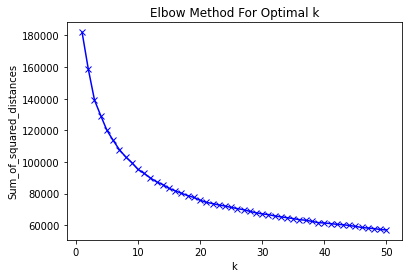

In [ ]:
plt.plot(K, SSE, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

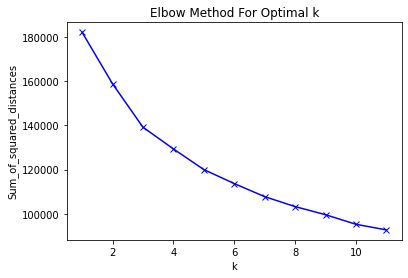

In [ ]:
plt.plot(K[0:11], SSE[0:11], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Choose K=3 as the elbow point.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=10000,init='k-means++').fit(X_train_std)

In [ ]:
kmeans_pred = kmeans.predict(X_train_std)
df_train_kmeans = pd.DataFrame(X_train)
df_train_kmeans.columns = preselect
df_train_kmeans['expected_use_time'] = y_train
df_train_kmeans['Kmeans3'] = kmeans_pred
df_train_kmeans

,level,speed,max_load,grid_distance,urgency,hour,bad_weather,source_lng,source_lat,target_lng,target_lat,source_type_DELIVERY,source_type_PICKUP,expected_use_time,Kmeans3
0,3.0,3.550617,8.0,2353.0,2760.0,20.0,0.0,121.654984,38.966321,121.669184,38.978351,1.0,0.0,1286,2
1,3.0,4.614005,10.0,545.0,892.0,15.0,0.0,121.559276,39.161311,121.557943,39.157795,0.0,1.0,103,0
2,3.0,6.244997,12.0,1078.0,-3222.0,9.0,1.0,121.798654,39.145237,121.799774,39.136731,0.0,1.0,440,0
3,0.0,5.995930,5.0,445.0,1197.0,12.0,0.0,121.528068,39.277275,121.529130,39.277430,0.0,1.0,2,0
4,2.0,5.100089,8.0,455.0,878.0,10.0,1.0,121.612775,39.133338,121.615824,39.132501,0.0,1.0,517,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,3.0,4.380333,11.0,1503.0,3080.0,18.0,0.0,121.654064,39.250361,121.660572,39.255916,1.0,0.0,345,2
13996,3.0,5.939374,10.0,3893.0,2179.0,11.0,0.0,121.455184,39.054251,121.472482,39.067926,1.0,0.0,448,2
13997,3.0,4.481415,9.0,613.0,2060.0,19.0,0.0,121.671614,39.170641,121.670746,39.170840,1.0,0.0,1095,2
13998,2.0,5.434815,9.0,117.0,3247.0,18.0,0.0,121.484743,39.164506,121.484190,39.165002,0.0,0.0,373,2


In [ ]:
cluster_num_train = dict(df_train_kmeans['Kmeans3'].value_counts())
print(cluster_num_train)

{2: 6708, 0: 6611, 1: 681}


In [ ]:
kmeans_pred_val = kmeans.predict(X_val_std)
df_val_kmeans = pd.DataFrame(X_val)
df_val_kmeans.columns = preselect
df_val_kmeans['expected_use_time'] = y_val
df_val_kmeans['Kmeans3'] = kmeans_pred_val
df_val_kmeans

,level,speed,max_load,grid_distance,urgency,hour,bad_weather,source_lng,source_lat,target_lng,target_lat,source_type_DELIVERY,source_type_PICKUP,expected_use_time,Kmeans3
0,3.0,6.186942,9.0,877.0,1704.0,9.0,0.0,121.595374,39.012591,121.593633,39.019497,1.0,0.0,376,2
1,2.0,4.709214,9.0,774.0,535.0,13.0,1.0,121.373504,39.135871,121.374704,39.130511,0.0,1.0,254,0
2,3.0,5.731900,9.0,129.0,2295.0,12.0,0.0,121.603724,39.023291,121.602474,39.022801,1.0,0.0,55,2
3,2.0,6.808357,6.0,1960.0,421.0,13.0,0.0,121.671642,39.335899,121.665744,39.325721,0.0,1.0,491,0
4,3.0,5.940060,8.0,201.0,1812.0,11.0,0.0,121.958775,39.593125,121.957098,39.592857,0.0,0.0,801,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,3.0,4.796082,9.0,2142.0,3019.0,11.0,0.0,121.808574,39.129551,121.817704,39.138351,1.0,0.0,605,2
5996,3.0,5.571490,11.0,2286.0,3307.0,12.0,0.0,121.622874,39.253611,121.604444,39.251341,1.0,0.0,575,2
5997,3.0,4.618290,9.0,1283.0,2740.0,8.0,0.0,122.227314,39.350311,122.235274,39.354291,1.0,0.0,223,1
5998,2.0,4.667710,8.0,1247.0,2663.0,13.0,1.0,121.565654,39.135981,121.563984,39.145401,1.0,0.0,525,2


In [ ]:
cluster_num_val = dict(df_val_kmeans['Kmeans3'].value_counts())
print(cluster_num_val)

{2: 2876, 0: 2829, 1: 295}


In [ ]:
df_train0 = df_train_kmeans[df_train_kmeans['Kmeans3']==0]
df_train1 = df_train_kmeans[df_train_kmeans['Kmeans3']==1]
df_train2 = df_train_kmeans[df_train_kmeans['Kmeans3']==2]


df_val0 = df_val_kmeans[df_val_kmeans['Kmeans3']==0]
df_val1 = df_val_kmeans[df_val_kmeans['Kmeans3']==1]
df_val2 = df_val_kmeans[df_val_kmeans['Kmeans3']==2]

## Kmeans and Tree

In [ ]:
preselect = ['grid_distance','source_type_DELIVERY', 'source_type_PICKUP','urgency']

In [ ]:
X_train0 = np.array(df_train0[preselect]).reshape([df_train0.shape[0],len(preselect)])
X_train1 = np.array(df_train1[preselect]).reshape([df_train1.shape[0],len(preselect)])
X_train2 = np.array(df_train2[preselect]).reshape([df_train2.shape[0],len(preselect)])

X_val0 = np.array(df_val0[preselect]).reshape([df_val0.shape[0],len(preselect)])
X_val1 = np.array(df_val1[preselect]).reshape([df_val1.shape[0],len(preselect)])
X_val2 = np.array(df_val2[preselect]).reshape([df_val2.shape[0],len(preselect)])

y_train0 = np.array(df_train0['expected_use_time'])
y_train1 = np.array(df_train1['expected_use_time'])
y_train2 = np.array(df_train2['expected_use_time'])

y_val0 = np.array(df_val0['expected_use_time'])
y_val1 = np.array(df_val1['expected_use_time'])
y_val2 = np.array(df_val2['expected_use_time'])

In [ ]:
param = {'ccp_alpha':np.logspace(-2, 2)}
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae')
gridCV6 = GridSearchCV(RegTree, param,scoring='neg_mean_absolute_error',cv=3).fit(X_train0,y_train0)
print("The best parameters are",gridCV6.best_params_) 

The best parameters are {'ccp_alpha': 0.35564803062231287}


In [ ]:
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=0.35564803062231287)
RegTree.fit(X_train0,y_train0)

y_pred_train = RegTree.predict(X_train0)
train_mae = mae(y_train0,y_pred_train)
print('in sample mae:',train_mae)

y_pred_val0 = RegTree.predict(X_val0)
val_mae = mae(y_val0,y_pred_val0)
print('out of sample mae:',val_mae)

in sample mae: 127.74466797761306
out of sample mae: 124.23577235772358


In [ ]:
param = {'ccp_alpha':np.logspace(-2, 2)}
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae')
gridCV7 = GridSearchCV(RegTree, param,scoring='neg_mean_absolute_error',cv=3).fit(X_train1,y_train1)
print("The best parameters are",gridCV7.best_params_) 

The best parameters are {'ccp_alpha': 4.094915062380423}


In [ ]:
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=4.094915062380423)
RegTree.fit(X_train1,y_train1)

y_pred_train = RegTree.predict(X_train1)
train_mae = mae(y_train1,y_pred_train)
print('in sample mae:',train_mae)

y_pred_val1 = RegTree.predict(X_val1)
val_mae = mae(y_val1,y_pred_val1)
print('out of sample mae:',val_mae)

in sample mae: 203.98825256975036
out of sample mae: 212.88135593220338


In [ ]:
param = {'ccp_alpha':np.logspace(-2, 2)}
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae')
gridCV8 = GridSearchCV(RegTree, param,scoring='neg_mean_absolute_error',cv=3).fit(X_train2,y_train2)
print("The best parameters are",gridCV8.best_params_) 

The best parameters are {'ccp_alpha': 0.7543120063354615}


In [ ]:
RegTree = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=0.7543120063354615)
RegTree.fit(X_train2,y_train2)

y_pred_train = RegTree.predict(X_train2)
train_mae = mae(y_train2,y_pred_train)
print('in sample mae:',train_mae)

y_pred_val2 = RegTree.predict(X_val2)
val_mae = mae(y_val2,y_pred_val2)
print('out of sample mae:',val_mae)

in sample mae: 257.47465712581993
out of sample mae: 262.173331015299


In [ ]:
y_pred_KmeansTree = np.append(y_pred_val0,y_pred_val1)
y_true = np.append(y_val0,y_val1)

y_pred_KmeansTree = np.append(y_pred_KmeansTree,y_pred_val2)
y_true = np.append(y_true,y_val2)


In [ ]:
mae_val = mae(y_true, y_pred_KmeansTree)
print("testing mae: ",mae_val)

testing mae:  194.71225


## Prediction

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['expected_use_time'])

In [ ]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
kmeans_whole = KMeans(n_clusters=3, random_state=0, max_iter=10000,init='k-means++').fit(X_std)

In [ ]:
kmeans_pred_whole = kmeans_whole.predict(X_std)
df_kmeans = pd.DataFrame(X)
df_kmeans.columns = preselect
df_kmeans['expected_use_time'] = y
df_kmeans['Kmeans3'] = kmeans_pred_whole
df_kmeans

,level,speed,max_load,grid_distance,urgency,hour,bad_weather,source_lng,source_lat,target_lng,target_lat,source_type_DELIVERY,source_type_PICKUP,expected_use_time,Kmeans3
0,3.0,4.751832,11.0,377.0,1246.0,11.0,0.0,121.630997,39.142343,121.632547,39.141946,0.0,0.0,804,2
1,3.0,4.751832,11.0,780.0,1246.0,11.0,0.0,121.632547,39.141946,121.626144,39.140281,0.0,1.0,298,0
2,3.0,4.751832,11.0,550.0,2462.0,11.0,0.0,121.626144,39.140281,121.631219,39.141811,1.0,0.0,545,2
3,3.0,4.751832,11.0,707.0,1205.0,11.0,0.0,121.631219,39.141811,121.632084,39.146201,0.0,1.0,341,0
4,3.0,4.751832,11.0,770.0,1882.0,11.0,0.0,121.632084,39.146201,121.631574,39.142231,1.0,0.0,166,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509599,3.0,5.573470,11.0,1.0,2300.0,12.0,1.0,121.445284,39.211421,121.444934,39.211511,1.0,0.0,2,2
509600,3.0,5.573470,11.0,476.0,2306.0,12.0,1.0,121.444934,39.211511,121.447360,39.211273,1.0,0.0,672,2
509601,3.0,5.573470,11.0,1.0,563.0,12.0,1.0,121.447360,39.211273,121.447360,39.211273,0.0,1.0,2,0
509602,3.0,5.573470,11.0,1255.0,988.0,12.0,1.0,121.447360,39.211273,121.453554,39.208541,0.0,1.0,333,0


In [ ]:
df_test.isna().sum()

courier_id                0
wave_index                0
tracking_id               0
courier_wave_start_lng    0
courier_wave_start_lat    0
date                      0
group                     0
level                     0
speed                     0
max_load                  0
weather_grade             0
aoi_id                    0
shop_id                   0
id                        0
source_tracking_id        0
source_lng                0
source_lat                0
target_lng                0
target_lat                0
grid_distance             0
urgency                   0
hour                      4
source_type_ASSIGN        0
source_type_DELIVERY      0
source_type_PICKUP        0
bad_weather               0
dtype: int64

In [ ]:
df_test.fillna(df_test.mean(),inplace=True)

In [ ]:
df_test.isna().sum()

courier_id                0
wave_index                0
tracking_id               0
courier_wave_start_lng    0
courier_wave_start_lat    0
date                      0
group                     0
level                     0
speed                     0
max_load                  0
weather_grade             0
aoi_id                    0
shop_id                   0
id                        0
source_tracking_id        0
source_lng                0
source_lat                0
target_lng                0
target_lat                0
grid_distance             0
urgency                   0
hour                      0
source_type_ASSIGN        0
source_type_DELIVERY      0
source_type_PICKUP        0
bad_weather               0
dtype: int64

In [ ]:
preselect = ['level','speed', 'max_load','grid_distance', 'urgency', 'hour', 'bad_weather','source_lng', 'source_lat', 'target_lng','target_lat','source_type_DELIVERY', 'source_type_PICKUP']
X_test = np.array(df_test[preselect]).reshape([df_test.shape[0],len(preselect)])
X_test_std = scaler.fit_transform(X_test)

In [ ]:
kmeans_pred_test = kmeans_whole.predict(X_test_std)
df_test_kmeans = pd.DataFrame(X_test)
df_test_kmeans.columns = preselect
df_test_kmeans['Kmeans3'] = kmeans_pred_test
df_test_kmeans

,level,speed,max_load,grid_distance,urgency,hour,bad_weather,source_lng,source_lat,target_lng,target_lat,source_type_DELIVERY,source_type_PICKUP,Kmeans3
0,3.0,5.535851,11.0,796.0,1776.0,13.0,0.0,121.630558,39.140900,121.629930,39.144603,0.0,0.0,2
1,3.0,5.535851,11.0,1048.0,697.0,13.0,0.0,121.629930,39.144603,121.629604,39.150661,0.0,1.0,0
2,3.0,5.535851,11.0,1019.0,1756.0,13.0,0.0,121.629604,39.150661,121.629930,39.144603,1.0,0.0,2
3,3.0,5.535851,11.0,1198.0,676.0,13.0,0.0,121.629930,39.144603,121.630544,39.152711,0.0,1.0,0
4,3.0,5.535851,11.0,1275.0,2336.0,14.0,0.0,121.630544,39.152711,121.631446,39.142762,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25463,3.0,5.681500,11.0,703.0,3872.0,19.0,0.0,121.457034,39.217461,121.453294,39.214381,1.0,0.0,2
25464,3.0,5.681500,11.0,1297.0,2043.0,19.0,0.0,121.453580,39.205943,121.450119,39.209546,0.0,0.0,2
25465,3.0,5.681500,11.0,233.0,1204.0,19.0,0.0,121.450119,39.209546,121.450644,39.207601,0.0,1.0,0
25466,3.0,5.681500,11.0,720.0,2948.0,19.0,0.0,121.450644,39.207601,121.452471,39.209303,1.0,0.0,2


In [ ]:
cluster_num_test = dict(df_test_kmeans['Kmeans3'].value_counts())
print(cluster_num_test)

{2: 12734, 0: 12732, 1: 2}


In [ ]:
df_0 = df_kmeans[df_kmeans['Kmeans3']==0]
df_1 = df_kmeans[df_kmeans['Kmeans3']==1]
df_2 = df_kmeans[df_kmeans['Kmeans3']==2]

df_test0 = df_test_kmeans[df_test_kmeans['Kmeans3']==0]
df_test1 = df_test_kmeans[df_test_kmeans['Kmeans3']==1]
df_test2 = df_test_kmeans[df_test_kmeans['Kmeans3']==2]

In [ ]:
preselect = ['grid_distance','source_type_DELIVERY', 'source_type_PICKUP','urgency']

In [ ]:
X_0 = np.array(df_0[preselect]).reshape([df_0.shape[0],len(preselect)])
X_1 = np.array(df_1[preselect]).reshape([df_1.shape[0],len(preselect)])
X_2 = np.array(df_2[preselect]).reshape([df_2.shape[0],len(preselect)])

X_test0 = np.array(df_test0[preselect]).reshape([df_test0.shape[0],len(preselect)])
X_test1 = np.array(df_test1[preselect]).reshape([df_test1.shape[0],len(preselect)])
X_test2 = np.array(df_test2[preselect]).reshape([df_test2.shape[0],len(preselect)])

y_0 = np.array(df_0['expected_use_time'])
y_1 = np.array(df_1['expected_use_time'])
y_2 = np.array(df_2['expected_use_time'])

In [ ]:
RegTree0 = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=0.35564803062231287)
RegTree0.fit(X_0,y_0)
y_pred_test0 = RegTree0.predict(X_test0)

In [ ]:
df_test0['y_pred'] = y_pred_test0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test0

,level,speed,max_load,grid_distance,urgency,hour,bad_weather,source_lng,source_lat,target_lng,target_lat,source_type_DELIVERY,source_type_PICKUP,Kmeans3,y_pred
1,3.0,5.535851,11.0,1048.0,697.0,13.0,0.0,121.629930,39.144603,121.629604,39.150661,0.0,1.0,0,318.0
3,3.0,5.535851,11.0,1198.0,676.0,13.0,0.0,121.629930,39.144603,121.630544,39.152711,0.0,1.0,0,318.0
5,3.0,5.535851,11.0,196.0,877.0,14.0,0.0,121.631446,39.142762,121.631219,39.141811,0.0,1.0,0,137.0
6,3.0,5.535851,11.0,1732.0,1136.0,14.0,0.0,121.631219,39.141811,121.624744,39.132501,0.0,1.0,0,435.0
9,3.0,5.535851,11.0,799.0,542.0,17.0,0.0,121.631045,39.142219,121.635774,39.142771,0.0,1.0,0,271.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25457,3.0,5.681500,11.0,3.0,847.0,18.0,0.0,121.452418,39.210218,121.452423,39.210229,0.0,1.0,0,3.0
25458,3.0,5.681500,11.0,59.0,1053.0,18.0,0.0,121.452423,39.210229,121.452226,39.209721,0.0,1.0,0,3.0
25459,3.0,5.681500,11.0,968.0,66.0,18.0,0.0,121.452226,39.209721,121.461584,39.211361,0.0,1.0,0,318.0
25465,3.0,5.681500,11.0,233.0,1204.0,19.0,0.0,121.450119,39.209546,121.450644,39.207601,0.0,1.0,0,137.0


In [ ]:
RegTree1 = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=4.094915062380423)
RegTree1.fit(X_1,y_1)
y_pred_test1 = RegTree1.predict(X_test1)
df_test1['y_pred'] = y_pred_test1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_test1

,level,speed,max_load,grid_distance,urgency,hour,bad_weather,source_lng,source_lat,target_lng,target_lat,source_type_DELIVERY,source_type_PICKUP,Kmeans3,y_pred
13090,2.0,5.835432,5.0,952.0,9.0,14.852419,1.0,39.171352,121.596844,39.152001,4299.0,0.0,0.0,1,261.0
13091,2.0,5.835432,5.0,460.0,10.0,14.852419,1.0,39.152001,121.567834,39.174131,4925.0,0.0,0.0,1,261.0


In [ ]:
RegTree2 = DecisionTreeRegressor(random_state=0,criterion='mae',ccp_alpha=0.7543120063354615)
RegTree2.fit(X_2,y_2)
y_pred_test2 = RegTree2.predict(X_test2)
df_test2['y_pred'] = y_pred_test2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_test2

,level,speed,max_load,grid_distance,urgency,hour,bad_weather,source_lng,source_lat,target_lng,target_lat,source_type_DELIVERY,source_type_PICKUP,Kmeans3,y_pred
0,3.0,5.535851,11.0,796.0,1776.0,13.0,0.0,121.630558,39.140900,121.629930,39.144603,0.0,0.0,2,466.0
2,3.0,5.535851,11.0,1019.0,1756.0,13.0,0.0,121.629604,39.150661,121.629930,39.144603,1.0,0.0,2,389.0
4,3.0,5.535851,11.0,1275.0,2336.0,14.0,0.0,121.630544,39.152711,121.631446,39.142762,1.0,0.0,2,389.0
7,3.0,5.535851,11.0,764.0,2674.0,14.0,0.0,121.624744,39.132501,121.622344,39.129621,1.0,0.0,2,292.0
8,3.0,5.535851,11.0,105.0,1799.0,17.0,0.0,121.630487,39.142419,121.631045,39.142219,0.0,0.0,2,466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25461,3.0,5.681500,11.0,1315.0,2123.0,19.0,0.0,121.456504,39.212481,121.452114,39.220391,1.0,0.0,2,389.0
25462,3.0,5.681500,11.0,1152.0,3590.0,19.0,0.0,121.452114,39.220391,121.457034,39.217461,1.0,0.0,2,389.0
25463,3.0,5.681500,11.0,703.0,3872.0,19.0,0.0,121.457034,39.217461,121.453294,39.214381,1.0,0.0,2,292.0
25464,3.0,5.681500,11.0,1297.0,2043.0,19.0,0.0,121.453580,39.205943,121.450119,39.209546,0.0,0.0,2,648.0


In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
df_test0.to_csv('reg_sub4_0.csv')
!cp reg_sub4_0.csv "drive/My Drive/"
df_test1.to_csv('reg_sub4_1.csv')
!cp reg_sub4_1.csv "drive/My Drive/"
df_test2.to_csv('reg_sub4_2.csv')
!cp reg_sub4_2.csv "drive/My Drive/"